## Imports

In [1]:
from PIL import Image
from io import BytesIO
from IPython.core import display
from matplotlib import pyplot as plt
import numpy as np
import cv2

%matplotlib inline
plt.rcParams['figure.dpi'] = 80
plt.rcParams['savefig.dpi'] = 80
plt.rcParams['figure.figsize'] = (6, 6)

Use javascript to avoid auto scroll in output cells.

In [2]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 5000;

<IPython.core.display.Javascript object>

##Basic display functions

In [3]:
cache = {}
def thumb_image(img, thumbsize=(400,400)):
    key = 0
    if type(img) == ImageFile:
        key = img.pk
        if key in cache:
            return cache.get(key) 
         
        img = Image.open(img.source_file.file.name)
    img.thumbnail(thumbsize,  Image.ANTIALIAS)
    cache[key] = img
    return img



def opencv_image(image, size=400):
    key = hash(image)
    if key in cache:
        cv2img = cache[key]
    else:
        cv2img = cv2.imread(image.source_file.file.name)
        w, h = cv2img.shape[0], cv2img.shape[1]
        if w > h:
            h, w = 400 * h // w, 400
        else:
            h, w = 400, 400 * w // h
        cv2img = cv2.resize(cv2img, (h, w)) 

        cache[key] = cv2img

    return cv2.cvtColor(cv2img, cv2.COLOR_BGR2RGB)

def image_to_bytes(image):
    b = BytesIO()
    image.save(b, format='png')
    return b

def display_pil_image(image):
    """Displayhook function for PIL Images, rendered as PNG."""
    b = image_to_bytes(image)
    ip_img = display.Image(data=b.getvalue(), format='png', embed=True)
    return ip_img._repr_png_()

# register display func with PNG formatter:
png_formatter = get_ipython().display_formatter.formatters['image/png']
dpi = png_formatter.for_type(Image.Image, display_pil_image)


In [4]:
## Big Function for viewing images

01:52:37 2015-10-20 [DEBUG] apps.photo.autocrop  autocrop.py:126  (main)
	Autocrop (50, 42) ansikter           31495 Julie-Bjander.jpg



Julie-Bjander.jpg


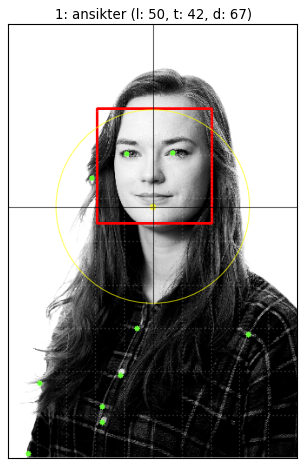

In [6]:
from math import ceil
from itertools import chain
import numpy as np
import cv2
import os

datafolder = '/srv/local.universitas.no/django/apps/photo/haarcascades/'
haar_classifier = os.path.join(datafolder, 'haarcascade_frontalface_default.xml')
assert os.path.exists(haar_classifier)
face_cascade = cv2.CascadeClassifier(haar_classifier)

def plot_grid(ax, cv2img):
    # Image grid overlay
    divisions = 10
    height, width = cv2img.shape[0], cv2img.shape[1] 
    yticks = [n * width / divisions for n in range(1, divisions)]
    xticks = [n * height / divisions for n in range(1, divisions)]
    lines = list( chain(*[[(0, width), (x, x)] for x in xticks] + [[ (y, y), (0, height),] for y in yticks] ))   
    plt.tick_params(length=0, direction='in', labelbottom=False, labelleft=False,)
    ax.set_xticks(xticks)
    ax.set_yticks(yticks)
    dash = 1.2
    ax.plot(*lines, ls='--', lw=dash, dashes=(1 * dash, 2 * dash), color=(1, 1, 1, .2))


def detect_faces(imgfile, cv2img, ax):
    gray = cv2.cvtColor(cv2img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, minSize=(30,30), minNeighbors=8)
    #       face_cascade.detectMultiScale(image[, scaleFactor[, minNeighbors[, flags[, minSize[, maxSize]]]]]
    for (fx,fy,fw,fh) in faces:
        cv2.rectangle(cv2img,(fx,fy),(fx+fw,fy+fh),(255,0,0),2)
        ver_cen, hor_cen = fx+fw/2, fy+fh/2
    

def detect_corners(imgfile, cv2img, ax):
    
    gray = cv2.cvtColor(cv2img, cv2.COLOR_BGR2GRAY)
    corners = cv2.goodFeaturesToTrack(gray,10,0.01,10)
    corners = np.int0(corners)
    
    for i in corners:
        x,y = i.ravel()
        cv2.circle(cv2img,(x,y),3,(100,255,50),-1)

            
    
def plot_center(imgfile, cv2img, ax):
    dotcolor = (1,1,0,.6)
    crosshaircolor = (0,0,0,.6)

    height, width = cv2img.shape[0], cv2img.shape[1]
    x, y = (imgfile.from_left/100) * width, (imgfile.from_top/100) * height
    d = (imgfile.crop_diameter/100) * min(width, height)

    ax.plot(x, y, 'o', mew=1, markersize=5, mec = dotcolor, c = dotcolor)
    ax.plot(x, y, '+', mew=1, markersize=800, color=crosshaircolor)
    circle=plt.Circle((x,y),d/2,color=dotcolor, fill=False)
    ax.add_artist(circle)
    

        
def image_grid(imagefiles, columns=2,):
    rows = ceil(len(imagefiles) / columns)
    plt.figure(figsize=(15 ,15//columns * rows))
    for n, imgfile in enumerate(imagefiles,1):
        #imgfile.autocrop()
        ax = plt.subplot(rows, columns, n)
        img = opencv_image(imgfile, size=1000//columns)
        plt.imshow(img)
        plot_grid(ax, img)
        
        detect_corners(imgfile, img, ax)
        detect_faces(imgfile, img, ax)
        #imgfile.save()
        plot_center(imgfile, img, ax)
        title = '{}: {} (l: {:2}, t: {:2}, d: {:2})'.format(
            n, imgfile.get_cropping_method_display(), imgfile.from_left, imgfile.from_top, imgfile.crop_diameter)
        plt.title(title)

        #print(title)

    plt.show()



def opencv_image(self, size=400):
    """ Convert ImageFile into a cv2 image for image processing. """
    self.source_file.open()
    with self.source_file as source:
        nparr = np.fromstring(source.read(), np.uint8)

    cv2img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
    cv2img = cv2.cvtColor(cv2img, cv2.COLOR_BGR2RGB)
    width, height = cv2img.shape[0], cv2img.shape[1]
    if width > height:
        height, width = size * height // width, size
    else:
        height, width = size, size * width // height

    cv2img = cv2.resize(cv2img, (height, width))
    return cv2img

all_imagefiles = ImageFile.objects.order_by('-pk').all()
feature_imagefiles = ImageFile.objects.order_by('id').filter(cropping_method=ImageFile.CROP_FEATURES)

imagefiles = all_imagefiles[8:9]
imagefiles = ImageFile.objects.filter(source_file__endswith='Julie-Bjander.jpg')
#ImageFile.opencv_image = opencv_image
for i in imagefiles:
    i.autocrop()
    print(i)
image_grid(imagefiles)

## Check that utility functions are working.

In [ ]:
i = ImageFile.objects.first()
img = opencv_image(i)
plt.figure()
plt.imshow(img)

In [ ]:

datafolder = '/srv/local.universitas.no/django/apps/photo/haarcascades/'
face_cascade = cv2.CascadeClassifier(datafolder+'haarcascade_frontalface_default.xml')
#face_cascade = cv2.CascadeClassifier(datafolder+'haarcascade_profileface.xml')

#eye_cascade = cv2.CascadeClassifier(datafolder+'haarcascade_eye.xml')

files = ImageFile.objects.all()
for n in (24,):
    fil = files[n]
    img = opencv_image(fil)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray,1.1 , 5)
    for (x,y,w,h) in faces:
        cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
    #plot_grid(ax, img)
    plt.imshow(img)

## CV2 basic edge detection og også pyplot matrisevisning

In [ ]:
# loading image
imgfile = ImageFile.objects.order_by('id')[0]
center = ImageFile.get_crop
img0 = opencv_image(imgfile)
x, y =  imgfile.from_left, imgfile.from_top
# converting to gray scale
gray = cv2.cvtColor(img0, cv2.COLOR_BGR2GRAY)

# remove noise
img = cv2.GaussianBlur(gray, (3, 3), 0)

# convolute with proper kernels
laplacian = cv2.Laplacian(img, cv2.CV_64F)
sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=5)  # x
sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=5)  # y

# set output figure size
plt.figure(figsize=(12, 8))

# contruct output plot
subplots = (
    ('Original', img0,),
    ('Laplacian', laplacian,),
    ('Sobel x', sobelx,),
    ('Sobel y', sobely,),
)
from matplotlib.ticker import FuncFormatter 
from itertools import chain

def myfunc(x, pos=0): 
    return '{x:d}%'.format(x=int(x)) 

number = 4
ticks = [n*100/number for n in range(1,number)]
lines = list( chain(* ([(0,100), (x,x), (x,x), (0,100)] for x in ticks) ) )


for n, (title, img) in enumerate(subplots, 1):
    ax = plt.subplot(2, 2, n)
    plt.tick_params(length=0, direction='in', labelbottom=False, labelleft=False,)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)   
    plt.title(title)
    plt.imshow(img, extent=[0, 100, 100, 0], cmap='gray', aspect='auto')
    
    # markør for bildecrop
    ax.plot(x,y,'x', linewidth=50, mew=1, markersize=10, color=(1,1,0))
    
    # grid
    dash = 1.2
    ax.plot(*lines, ls='--', lw=dash, dashes=(1*dash, 2*dash), color=(1,1,1,.4))


    
plt.show()


In [ ]:
imgfile = ImageFile.objects.get(source_file__icontains='sondre-jahr-nygaard')
cv2img = opencv_image(imgfile)

# Shi-Tomasi Corner Detector & Good Features to Track
gray = cv2.cvtColor(cv2img,cv2.COLOR_BGR2GRAY)

corners = cv2.goodFeaturesToTrack(gray,25,0.01,10)
corners = np.int0(corners)

In [ ]:
gray.shape

In [ ]:
height, width = gray.shape
imgfile.from_top = round(100 * corners.ravel()[1::2].mean() / height)
imgfile.from_left = round(100 * corners.ravel()[::2].mean() / width)
imgfile.save()

for i in corners:
    x,y = i.ravel()
    cv2.circle(cv2img,(x,y),3,255,-1)

fig, ax = plt.subplots()
plt.imshow(cv2img)
plot_grid(ax, img)
plot_center(imgfile, cv2img, ax)

plt.show()